<a href="https://colab.research.google.com/github/jcalandra/audiosynthesis_dl/blob/master/src/Pict2Audio_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pict2Audio : A Neural Network that associates Pictures to Audio Descriptors
This project consists in associating a sound with one or more characteristics defined by audio descriptors with a picture drawn by a composer . The long-term goal is to allow the composer to develop his own composition graphic language in order to associate it with sounds from some effects banks.

 
 ## Sound classification

In this study, I'm interested into pitch, volume and tone color features, and I will propose as input to a Convolutional Neural Network trained for classification a database composed of :
* sounds from the audio libraries of the composer,
* three labels for each audio, corresponding to the features in the labels associated to sound features. 

## Importation of the python librairies

In [1]:
print('[INFO] loading the librairies...')
from __future__ import print_function
import os
import glob

import numpy as np
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt

import librosa
from librosa import display

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.optimizers import RMSprop
from keras import callbacks
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPool2D, Flatten
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

[INFO] loading the librairies...
tensorflow: 1.14.0-rc1
keras: 2.2.4


Using TensorFlow backend.


In [2]:
! git clone https://github.com/jcalandra/audiosynthesis_dl.git

Cloning into 'audiosynthesis_dl'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 1625 (delta 14), reused 289 (delta 8), pack-reused 1330
Receiving objects: 100% (1625/1625), 148.09 MiB | 30.67 MiB/s, done.
Resolving deltas: 100% (240/240), done.
Checking out files: 100% (1121/1121), done.


In [0]:
NB_PITCH = 12
NB_THICK = 5
NB_COLOR = 8
NB_CARACTERISTICS = 4

SAMPLE_RATE = 16000
INPUT_LENGTH = SAMPLE_RATE*4
batch_size = 32
NB_MELS = 320

## Processing MelSpectrograms

In [0]:
# def audio_norm(data):
#
#     max_data = np.max(data)
#     min_data = np.min(data)
#     data = (data-min_data)/(max_data-min_data+0.0001)
#     return data-0.5

def preprocess_audio_mel(audio, sample_rate=SAMPLE_RATE, window_size=20, #log_specgram
                 step_size=10, eps=1e-10):

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= NB_MELS)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 80)/80

    return mel_db


def load_audio_file(file_path, input_length=INPUT_LENGTH):
    data = librosa.core.load(file_path, sr=SAMPLE_RATE)[0] #, sr=16000
    if len(data)>input_length:     
        max_offset = len(data)-input_length       
        offset = np.random.randint(max_offset)     
        data = data[offset:(input_length+offset)]          
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0           
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")      
    data = preprocess_audio_mel(data)
    return data

In [5]:
#just to undersstand how it works
data1 = librosa.core.load("./audiosynthesis_dl/data/bdd_snd/snd_train/flute_acoustic_002-069-025.wav", sr=16000)[0] #, sr=16000
print(len(data1))

data_base1 = load_audio_file('./audiosynthesis_dl/data/bdd_snd/snd_train/flute_acoustic_002-069-025.wav')
print(len(data_base1))

64000
320


In [6]:
snd_train = glob.glob("./audiosynthesis_dl/data/bdd_snd/tone/tone_train/*.wav") #train_files
snd_validation = glob.glob("./audiosynthesis_dl/data/bdd_snd/tone/tone_validation/*.wav") 

NB_TRAIN = len(snd_train)
NB_VALIDATION = len(snd_validation)

print(snd_train)
print(NB_TRAIN)

['./audiosynthesis_dl/data/bdd_snd/tone/tone_train/reed_acoustic_023-072-100-med.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/string_acoustic_057-077-075-low.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/string_acoustic_057-079-050-med.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/string_acoustic_057-078-025-high.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/vocal_synthetic_003-078-100-high.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/reed_acoustic_023-071-025-low.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/vocal_synthetic_003-079-050-high.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/string_acoustic_057-074-050-low.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/flute_synthetic_000-077-075-med.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/organ_electronic_057-077-050-low.wav', './audiosynthesis_dl/data/bdd_snd/tone/tone_train/reed_acoustic_023-069-127-high.wav', './audiosynthesis_dl/data/bdd_sn

In [0]:
def generate_mels(snd_tab):
  x_tab = np.empty((len(snd_tab),320,126, 1))
  for i in range(len(snd_tab)) :
    x_tab_i = np.reshape(load_audio_file(snd_tab[i]),(1,320,126,1))
    x_tab[i] = x_tab_i
  return x_tab
    

In [8]:
print('[INFO] generation of train mel spectrograms...')
x_train = generate_mels(snd_train)
print('[INFO] generation of validation mel spectrograms...')
x_validation = generate_mels(snd_validation)


print(x_train)
print(len(x_train))

[INFO] generation of train mel spectrograms...
[INFO] generation of validation mel spectrograms...
[[[[0.        ]
   [0.        ]
   [0.00605467]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.16668915]
   [0.15425225]
   [0.11003562]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.30998845]
   [0.2700085 ]
   [0.1664246 ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.12878306]
   [0.16518224]
   [0.16714576]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.04942672]
   [0.0933189 ]
   [0.09728646]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.17489431]
   [0.15976507]
   [0.14259642]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.32689149]
   [0.33721292]
   [0.35657759]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.33708253]
   [0.40584711]
   [0.4360953 ]
   .

## Processing Labels

In [0]:
def create_label_tab(sndPath_tab):
  """create a tab of labels considering a tab of filenames filenames_tab"""
  labels_tab = []
  for sndP in sndPath_tab:
    snd = sndP.split('.')[0]
    l = snd.split("-")
    labels = l[:NB_CARACTERISTICS]
    labels_tab.append(labels)
  return labels_tab

def gen_features_tabs(y_tab, y_feature, i_feature) :
  ''' generate a tab containing the labels for one specific feature '''
  for i in range(len(y_tab)) :
    y_feature[i] = y_tab[i][i_feature]

In [10]:
sndPath_train = os.listdir( "./audiosynthesis_dl/data/bdd_snd/tone/tone_train")[:]
sndPath_validation = os.listdir( "./audiosynthesis_dl/data/bdd_snd/tone/tone_validation")[:]

label_train = create_label_tab(sndPath_train)
label_validation = create_label_tab(sndPath_validation)

print(label_train)
print(label_validation)

[['reed_acoustic_023', '072', '100', 'med'], ['string_acoustic_057', '077', '075', 'low'], ['string_acoustic_057', '079', '050', 'med'], ['string_acoustic_057', '078', '025', 'high'], ['vocal_synthetic_003', '078', '100', 'high'], ['reed_acoustic_023', '071', '025', 'low'], ['vocal_synthetic_003', '079', '050', 'high'], ['string_acoustic_057', '074', '050', 'low'], ['flute_synthetic_000', '077', '075', 'med'], ['organ_electronic_057', '077', '050', 'low'], ['reed_acoustic_023', '069', '127', 'high'], ['flute_synthetic_000', '076', '025', 'high'], ['vocal_synthetic_003', '072', '050', 'low'], ['vocal_synthetic_003', '073', '050', 'low'], ['reed_acoustic_023', '074', '127', 'high'], ['vocal_synthetic_003', '080', '050', 'low'], ['organ_electronic_057', '077', '075', 'high'], ['brass_acoustic_006', '070', '127', 'high'], ['string_acoustic_057', '077', '050', 'med'], ['keyboard_synthetic_000', '072', '050', 'high'], ['string_acoustic_057', '079', '025', 'med'], ['string_acoustic_057', '072

In [0]:
# converts into int between 0 and n

def label2int(label_tab):
  """converts the label tab into int between 0 and n """
  y_tab = []
  for i in range(len(label_tab)):
    label_tab_i = []
    #pitch labelisation
    pitch = int(label_tab[i][1]) - 69
    #thick labelisation
    label_thick = label_tab[i][3]
    if(label_thick == 'low'):
      thick = 0
    elif (label_thick == 'med'):
      thick = 1
    else :
      thick = 2
    #color labelisation
    #TODO : adapter à 8 couleurs
    label_color = label_tab[i][0].split('_')[0]
    if (label_color == 'brass'):
      color = 0
    elif (label_color == 'guitar'):
      color = 1
    elif (label_color == 'keyboard'):
      color = 2
    elif (label_color == 'organ'):
      color = 3
    elif (label_color == 'string'):
      color = 4
    elif (label_color == 'vocal'):
      color = 5
    elif (label_color == 'flute'):
      color = 6
    else :
      color = 7    
    label_tab_i.append(color)
    label_tab_i.append(pitch)
    label_tab_i.append(thick)
    y_tab.append(label_tab_i)  
  return y_tab

In [12]:
print('[INFO] convertion of train labels into int...')
y_train = label2int(label_train)
print('[INFO] convertion of validation labels into int...')
y_validation = label2int(label_validation)

print(y_train)
print(y_validation)

[INFO] convertion of train labels into int...
[INFO] convertion of validation labels into int...
[[7, 3, 1], [4, 8, 0], [4, 10, 1], [4, 9, 2], [5, 9, 2], [7, 2, 0], [5, 10, 2], [4, 5, 0], [6, 8, 1], [3, 8, 0], [7, 0, 2], [6, 7, 2], [5, 3, 0], [5, 4, 0], [7, 5, 2], [5, 11, 0], [3, 8, 2], [0, 1, 2], [4, 8, 1], [2, 3, 2], [4, 10, 1], [4, 3, 0], [0, 10, 1], [7, 6, 1], [3, 8, 1], [2, 6, 2], [0, 11, 1], [4, 8, 2], [3, 5, 0], [6, 6, 0], [0, 1, 1], [6, 3, 2], [7, 6, 2], [0, 4, 0], [6, 2, 1], [7, 0, 1], [4, 4, 1], [0, 10, 0], [7, 5, 1], [7, 8, 1], [4, 10, 0], [4, 8, 2], [0, 10, 2], [3, 8, 0], [3, 4, 2], [4, 10, 0], [7, 3, 1], [6, 3, 0], [3, 1, 2], [6, 3, 1], [0, 1, 0], [7, 3, 2], [5, 9, 1], [0, 5, 2], [0, 11, 2], [4, 2, 2], [6, 4, 2], [7, 3, 0], [1, 8, 0], [2, 7, 2], [2, 3, 0], [4, 1, 2], [3, 1, 0], [3, 0, 2], [1, 8, 2], [7, 0, 0], [2, 7, 1], [2, 4, 0], [1, 0, 1], [1, 2, 2], [4, 1, 0], [3, 0, 0], [5, 5, 1], [6, 6, 1], [1, 4, 1], [5, 2, 1], [6, 8, 2], [7, 1, 1], [2, 3, 2], [4, 8, 0], [2, 6, 0], 

In [13]:
## GENERATION OF THE PITCH FEATURES TABS

print('[INFO] generation of the pitch features tabs...')
y_train_pitch = np.empty(NB_TRAIN)
y_validation_pitch = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_pitch, 1)
gen_features_tabs(y_validation, y_validation_pitch, 1)

print(y_train_pitch)
print(y_validation_pitch)

# Convert class vectors to binary class matrices ("one hot encoding")
print('[INFO] converting pitch class vectors...')
y_train_pitch = keras.utils.to_categorical(y_train_pitch, NB_PITCH)
y_validation_pitch = keras.utils.to_categorical(y_validation_pitch, NB_PITCH)

print('y_train_pitch.shape =', y_train_pitch.shape)
print('y_validation_pitch.shape =', y_validation_pitch.shape)

[INFO] generation of the pitch features tabs...
[ 3.  8. 10.  9.  9.  2. 10.  5.  8.  8.  0.  7.  3.  4.  5. 11.  8.  1.
  8.  3. 10.  3. 10.  6.  8.  6. 11.  8.  5.  6.  1.  3.  6.  4.  2.  0.
  4. 10.  5.  8. 10.  8. 10.  8.  4. 10.  3.  3.  1.  3.  1.  3.  9.  5.
 11.  2.  4.  3.  8.  7.  3.  1.  1.  0.  8.  0.  7.  4.  0.  2.  1.  0.
  5.  6.  4.  2.  8.  1.  3.  8.  6.  3.  4.  2.  4.  9.  5.  1.  1.  3.
  3.  1. 10.  3.  7. 10.  8.  3. 10.  9.  5. 11.  7.  8.  2. 10.  4.  0.
  1.  9. 10.  8.  3.  2.  3.  5.  5. 11. 11.  5.  4.  0. 11.  5.  0.  2.
  1. 10.  4.  4.  6.  9. 11. 10. 10.  0.  4.  3. 10.  7.  9.  8.  1.  9.
  1. 11.  4. 10.  5.  5.  6.  2.  4. 10.  0.  6.  5.  1.  0. 10. 10.  1.
  5. 10.  5.  2.  2.  4.  8.  4.  7.  5.  4.  4.  7. 11.  2.  5.  3.  2.
  0.  6.  3.  9.  5.  1.  1.  6. 10.  2.  7.  4.  5.  2.  4.  2.  1.  1.
 11.  4.  6.  7.  6.  4.  5.  5.  5.  4.  4.  7.  3.  0.  2.  5.  0.  4.
  6. 11.  8.  7.  3.  9.  0.  5.  4.  1. 11.  4.  8.  7.  4.  4.  0. 11.
  3

## Plot the Mel Spectrogram

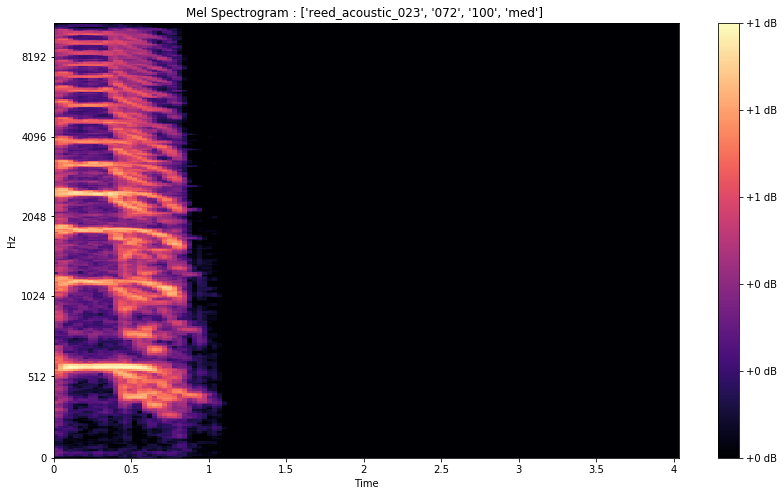

In [14]:
## PLOT THE MELSPECTROGRAM

data_base = load_audio_file(snd_train[0])
fig = plt.figure(figsize=(14, 8))
plt.title('Mel Spectrogram : %s ' % (label_train[0]))
librosa.display.specshow(data_base, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+02.0f dB')

## Training the Neural Networks

### Pitch Convolutional Neural Network

In [15]:
## CREATION OF THE NEURAL NETWORK

model_pitch = Sequential()

model_pitch.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_pitch.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_pitch.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model_pitch.add(Dropout(rate=0.2))

model_pitch.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_pitch.add(BatchNormalization(axis=-1))
model_pitch.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model_pitch.add(Dropout(rate=0.2))

# first (and only) set of FC => RELU layers
model_pitch.add(Flatten())
model_pitch.add(Dense(1024))
model_pitch.add(Activation("relu"))
model_pitch.add(BatchNormalization())
model_pitch.add(Dropout(rate=0.5))
 
# use a *sigmoid* activation for multi-label classification
model_pitch.add(Dense(NB_PITCH))
model_pitch.add(Activation('softmax'))

opt_pitch = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_pitch.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_pitchsnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_pitch = model_pitch.fit(x_train, y_train_pitch, validation_data=(x_validation, y_validation_pitch), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_pitch = model_pitch.evaluate(x_validation, y_validation_pitch, batch_size=32)
print('loss =', loss_and_metrics_pitch[0],'accuracy =', loss_and_metrics_pitch[1]);

model_pitch.summary();

W0626 17:02:43.629460 140318846330752 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 17:02:43.695384 140318846330752 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 17:02:43.714957 140318846330752 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 17:02:43.717988 140318846330752 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 17:02:43.774108 140318846330752 deprecation_wrappe

Train on 282 samples, validate on 87 samples
Epoch 1/100
282/282 [==============================] - 47s 168ms/step - loss: 2.8197 - acc: 0.3156 - val_loss: 2.5021 - val_acc: 0.3563
Epoch 2/100
282/282 [==============================] - 44s 156ms/step - loss: 1.1809 - acc: 0.6738 - val_loss: 1.6214 - val_acc: 0.5632
Epoch 3/100
282/282 [==============================] - 44s 155ms/step - loss: 0.8193 - acc: 0.7943 - val_loss: 0.8988 - val_acc: 0.7126
Epoch 4/100
282/282 [==============================] - 44s 157ms/step - loss: 0.5020 - acc: 0.8440 - val_loss: 0.5759 - val_acc: 0.8621
Epoch 5/100
282/282 [==============================] - 44s 157ms/step - loss: 0.2950 - acc: 0.9149 - val_loss: 0.9760 - val_acc: 0.7816
Epoch 6/100
282/282 [==============================] - 44s 157ms/step - loss: 0.3500 - acc: 0.9043 - val_loss: 0.6073 - val_acc: 0.8276
Epoch 7/100
282/282 [==============================] - 44s 157ms/step - loss: 0.1543 - acc: 0.9539 - val_loss: 0.5125 - val_acc: 0.8276
Epo

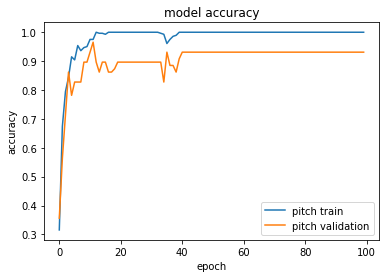

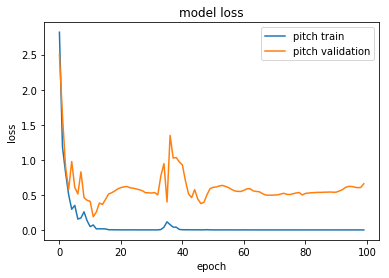

In [16]:
# summarize history for accuracy
plt.plot(hist_pitch.history['acc'])
plt.plot(hist_pitch.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pitch train', 'pitch validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_pitch.history['loss'])
plt.plot(hist_pitch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pitch train', 'pitch validation'], loc='upper right')
plt.show()


del y_train_pitch
del y_validation_pitch

résults : 
* C2D(32)+2xC2D(64)+2xC2D(128)+Dropout(0.2)+2xC2D(264)+Dropout(0.2)+dense(1024)+Dropout(0.5)
* epoch = 100, batch size = 32, opt adam
* loss: 4.9768e-05 - acc: 1.0000 - val_loss: 0.6577 - val_acc: 0.9310

### thick convolutional network

In [17]:
## GENERATION OF THE THICK==VOLUME FEATURES TABS

print('[INFO] generation of the thick features tabs...')
y_train_thick = np.empty(NB_TRAIN)
y_validation_thick = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_thick, 2)
gen_features_tabs(y_validation, y_validation_thick, 2)

print('[INFO] converting thick class vectors...')
y_train_thick = keras.utils.to_categorical(y_train_thick, NB_THICK)
y_validation_thick = keras.utils.to_categorical(y_validation_thick, NB_THICK)

print('y_train_thick.shape =', y_train_thick.shape)
print('y_validation_thick.shape =', y_validation_thick.shape)

[INFO] generation of the thick features tabs...
[INFO] converting thick class vectors...
y_train_thick.shape = (282, 5)
y_validation_thick.shape = (87, 5)


In [18]:
## CREATION OF THE THICK NEURAL NETWORK

model_thick = Sequential()

model_thick.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_thick.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_thick.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

model_thick.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_thick.add(BatchNormalization(axis=-1))
model_thick.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# first (and only) set of FC => RELU layers
model_thick.add(Flatten())
model_thick.add(Dense(1024))
model_thick.add(Activation("relu"))
model_thick.add(BatchNormalization())
 
# use a *sigmoid* activation for multi-label classification
model_thick.add(Dense(NB_THICK))
model_thick.add(Activation('softmax'))

model_thick.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_thicksnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_thick = model_thick.fit(x_train, y_train_thick, validation_data=(x_validation, y_validation_thick), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_thick = model_thick.evaluate(x_validation, y_validation_thick, batch_size=32)
print('loss =', loss_and_metrics_thick[0],'accuracy =', loss_and_metrics_thick[1]);

model_thick.summary();

Train on 282 samples, validate on 87 samples
Epoch 1/100
282/282 [==============================] - 82s 292ms/step - loss: 3.0583 - acc: 0.2908 - val_loss: 7.0050 - val_acc: 0.4023
Epoch 2/100
282/282 [==============================] - 79s 280ms/step - loss: 1.9173 - acc: 0.3440 - val_loss: 9.1913 - val_acc: 0.1379
Epoch 3/100
282/282 [==============================] - 79s 280ms/step - loss: 1.3401 - acc: 0.4255 - val_loss: 7.0181 - val_acc: 0.3333
Epoch 4/100
282/282 [==============================] - 79s 280ms/step - loss: 1.2816 - acc: 0.4184 - val_loss: 5.0174 - val_acc: 0.4023
Epoch 5/100
282/282 [==============================] - 79s 280ms/step - loss: 1.1871 - acc: 0.4397 - val_loss: 3.2570 - val_acc: 0.4483
Epoch 6/100
282/282 [==============================] - 79s 280ms/step - loss: 1.1046 - acc: 0.4149 - val_loss: 1.8955 - val_acc: 0.4713
Epoch 7/100
282/282 [==============================] - 79s 280ms/step - loss: 1.0632 - acc: 0.4539 - val_loss: 1.2754 - val_acc: 0.4713
Epo

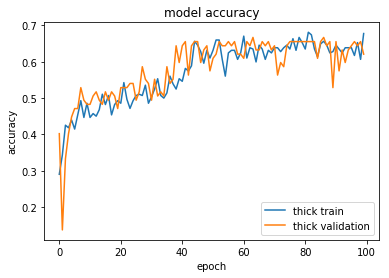

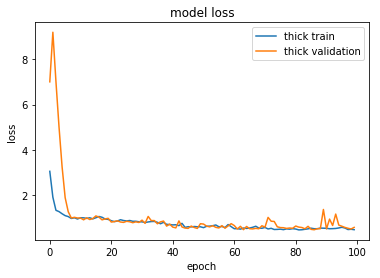

In [19]:
# summarize history for accuracy
plt.plot(hist_thick.history['acc'])
plt.plot(hist_thick.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['thick train', 'thick validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_thick.history['loss'])
plt.plot(hist_thick.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['thick train', 'thick validation'], loc='upper right')
plt.show()


del y_train_thick
del y_validation_thick

résults : 
* 2xC2D(32)+2xC2D(64)+3xC2D(128)+2xC2D(264)+dense(1024)
* epoch = 100, batch size = 32, opt adam
* loss: 0.5038 - acc: 0.6064 - val_loss: 0.5148 - val_acc: 0.6552

### color convolutional neural network


In [20]:
## GENERATION OF THE COLOR==TONE FEATURES TABS

print('[INFO] generation of the color features tabs...')
y_train_color = np.empty(NB_TRAIN)
y_validation_color = np.empty(NB_VALIDATION)

gen_features_tabs(y_train, y_train_color, 0)
gen_features_tabs(y_validation, y_validation_color, 0)

print('[INFO] converting color class vectors...')
y_train_color = keras.utils.to_categorical(y_train_color, NB_COLOR)
y_validation_color = keras.utils.to_categorical(y_validation_color, NB_COLOR)

[INFO] generation of the color features tabs...
[INFO] converting color class vectors...


In [21]:
## CREATION OF THE COLOR NEURAL NETWORK

model_color = Sequential()

model_color.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(3,3), strides=None, padding='valid', data_format=None))
              
# (CONV => RELU) * 2 => POOL
model_color.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# (CONV => RELU) * 2 => POOL
model_color.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

model_color.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'))
model_color.add(BatchNormalization(axis=-1))
model_color.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))

# first (and only) set of FC => RELU layers
model_color.add(Flatten())
model_color.add(Dense(1024))
model_color.add(Activation("relu"))
model_color.add(BatchNormalization())
model_color.add(Dropout(rate=0.5))
 
# use a *sigmoid* activation for multi-label classification
model_color.add(Dense(NB_COLOR))
model_color.add(Activation('softmax'))

opt_color= keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_color.compile(loss='categorical_crossentropy', optimizer=opt_color, metrics=['accuracy'])
cb = callbacks.ModelCheckpoint('model_colorsnd.h5', save_best_only=True, period=1)
#model.load_weights("baseline_cnn.h5")

hist_color = model_color.fit(x_train, y_train_color, validation_data=(x_validation, y_validation_color), epochs=100, batch_size = 32, callbacks=[cb])
loss_and_metrics_color = model_color.evaluate(x_validation, y_validation_color, batch_size=32)
print('loss =', loss_and_metrics_color[0],'accuracy =', loss_and_metrics_color[1]);

model_color.summary();

Train on 282 samples, validate on 87 samples
Epoch 1/100
282/282 [==============================] - 47s 166ms/step - loss: 1.1383 - acc: 0.6738 - val_loss: 0.1738 - val_acc: 0.9425
Epoch 2/100
282/282 [==============================] - 43s 154ms/step - loss: 0.0530 - acc: 0.9858 - val_loss: 0.0290 - val_acc: 1.0000
Epoch 3/100
282/282 [==============================] - 43s 154ms/step - loss: 0.0199 - acc: 0.9965 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 4/100
282/282 [==============================] - 44s 155ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 5/100
282/282 [==============================] - 44s 156ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 6/100
282/282 [==============================] - 44s 156ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 7/100
282/282 [==============================] - 44s 156ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epo

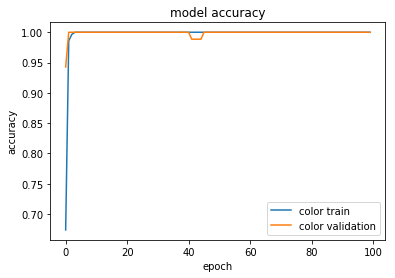

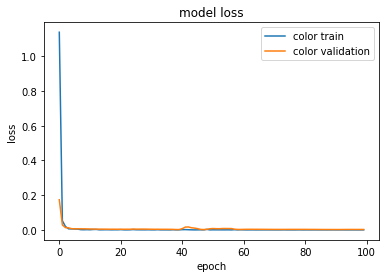

In [22]:
# summarize history for accuracy
plt.plot(hist_color.history['acc'])
plt.plot(hist_color.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['color train', 'color validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(hist_color.history['loss'])
plt.plot(hist_color.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['color train', 'color validation'], loc='upper right')
plt.show()

del y_train_color
del y_validation_color

résults :

* C2D(32)+2xC2D(64)+2xC2D(128)+2xC2D(264)+dense(1024)+Dropout(0.5)
* epoch = 100, batch size = 32, opt adam
* 154ms/step - loss: 1.2560e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000

## Test

In [0]:
def test_accuracy(y_tab, y_guessed):
  accuracy_sum = 0
  for i in range(len(y_tab)) :
    if(y_tab[i] == y_guessed[i]):
      accuracy_sum += 1
  accuracy = float(accuracy_sum) / float(len(y_guessed))
  print('accuracy = ', accuracy)

In [24]:

snd_test = glob.glob("./audiosynthesis_dl/data/bdd_snd/tone/tone_test/*.wav") #test_files
NB_TEST = len(snd_test)

print('[INFO] generation of test mel spectrograms...')
x_test = generate_mels(snd_test)

sndPath_test = os.listdir( "./audiosynthesis_dl/data/bdd_snd/tone/tone_test")[:]
label_test = create_label_tab(sndPath_test)
print(label_test)

print('[INFO] convertion of test labels into int...')
y_teststat = label2int(label_test)
print(y_teststat)

y_teststat_pitch = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_pitch, 1)
print(y_teststat_pitch)

y_teststat_thick = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_thick, 2)

y_teststat_color = np.empty(NB_TEST)
gen_features_tabs(y_teststat, y_teststat_color, 0)


print("[INFO] loading networks...")
model_pitch = load_model('model_pitchsnd.h5')
model_thick = load_model('model_thicksnd.h5')
model_color = load_model('model_colorsnd.h5')

y_test_pitch = model_pitch.predict_classes(x_test)
y_test_thick = model_thick.predict_classes(x_test)
y_test_color = model_color.predict_classes(x_test)

# show the inputs and predicted outputs
for i in range(len(y_test_pitch)):
  print("label y_test_pitch[%s] = %s, label y_teststat_pitch[%s] = %s " % (i, y_test_pitch[i], i, y_teststat_pitch[i]))
  print("label y_test_thick[%s] = %s, label y_teststat_thick[%s] = %s " % (i, y_test_thick[i], i, y_teststat_thick[i]))
  print("label y_test_color[%s] = %s, label y_teststat_color[%s] = %s \n" % (i, y_test_color[i], i, y_teststat_color[i]))
  
print('pitch :')
test_accuracy(y_teststat_pitch, y_test_pitch)
print('thick :')
test_accuracy(y_teststat_thick, y_test_thick)
print('color :')
test_accuracy(y_teststat_color, y_test_color)

[INFO] generation of test mel spectrograms...
[['brass_acoustic_006', '072', '050', 'high'], ['vocal_synthetic_003', '070', '127', 'med'], ['brass_acoustic_006', '079', '050', 'high'], ['vocal_synthetic_003', '070', '127', 'low'], ['brass_acoustic_006', '072', '050', 'med'], ['guitar_acoustic_021', '071', '100', 'med'], ['organ_electronic_057', '075', '025', 'med'], ['organ_electronic_057', '075', '025', 'high'], ['flute_synthetic_000', '073', '127', 'high'], ['reed_acoustic_023', '069', '075', 'low'], ['keyboard_synthetic_000', '077', '050', 'low'], ['guitar_acoustic_021', '076', '025', 'low'], ['organ_electronic_057', '078', '075', 'high'], ['brass_acoustic_006', '079', '050', 'med'], ['string_acoustic_057', '080', '127', 'med'], ['keyboard_synthetic_000', '077', '050', 'high'], ['keyboard_synthetic_000', '074', '100', 'med'], ['organ_electronic_057', '078', '075', 'low'], ['keyboard_synthetic_000', '074', '100', 'high'], ['keyboard_synthetic_000', '074', '100', 'low'], ['string_acou